## Predictive Analytics 

The aim of this workbook is to provide an in-depth statistical analysis of the current customer’s purchase history for a high-end furniture store in order predict the total estimated profit for a new collection of customers. 

<p algin="center">
<img src="https://www.r-project.org/Rlogo.png">
</p>

In [2]:
#load R packages
library('ggplot2')
#Machine Learning Package
library('caret')
#Set working directory to root
setwd('.')

Loading required package: lattice


In [3]:
#Read data into csv
df <- read.csv("customers.csv",sep=",",header=TRUE)
#return the first two rows and check if data imported correctly
head(df,2) 

Name,Customer_Segment,Customer_ID,Address,City,State,ZIP,Avg_Sale_Amount,Store_Number,Responded_to_Last_Catalog,Avg_Num_Products_Purchased,No_Years_as_Customer
Pamela Wright,Store Mailing List,2,376 S Jasmine St,Denver,CO,80224,227.9,100,No,1,6
Danell Valdez,Store Mailing List,7,12066 E Lake Cir,Greenwood Village,CO,80111,55.0,105,Yes,1,6


In [4]:
#Reorder the DataFrame 
#First 5 columns are irrelevant in this dataset -- easier to subset the data
df <- df[c('Name','Customer_ID','Address','State','ZIP','City','Store_Number',
          'Customer_Segment','Responded_to_Last_Catalog','Avg_Num_Products_Purchased',
           'No_Years_as_Customer','Avg_Sale_Amount')]
head(df,2)

Name,Customer_ID,Address,State,ZIP,City,Store_Number,Customer_Segment,Responded_to_Last_Catalog,Avg_Num_Products_Purchased,No_Years_as_Customer,Avg_Sale_Amount
Pamela Wright,2,376 S Jasmine St,CO,80224,Denver,100,Store Mailing List,No,1,6,227.9
Danell Valdez,7,12066 E Lake Cir,CO,80111,Greenwood Village,105,Store Mailing List,Yes,1,6,55.0


In [5]:
#loop through and print out the data type for each column
for(i in names(df)){
  print(str(i))
}

 chr "Name"
NULL
 chr "Customer_ID"
NULL
 chr "Address"
NULL
 chr "State"
NULL
 chr "ZIP"
NULL
 chr "City"
NULL
 chr "Store_Number"
NULL
 chr "Customer_Segment"
NULL
 chr "Responded_to_Last_Catalog"
NULL
 chr "Avg_Num_Products_Purchased"
NULL
 chr "No_Years_as_Customer"
NULL
 chr "Avg_Sale_Amount"
NULL


In [6]:
#convert character columns that are numeric to numeric
df$Avg_Sale_Amount<-as.numeric(df$Avg_Sale_Amount)
df$No_Years_as_Customer<-as.numeric(df$No_Years_as_Customer)

#check if data type is changed to numeric
str(df$Avg_Sale_Amount)
str(df$No_Years_as_Customer)

 num [1:2375] 228 55 213 195 111 ...
 num [1:2375] 6 6 3 6 2 8 7 1 2 6 ...


In [7]:
#subset the data by not including the first 5 columns
df<-df[,c(6:length(df))]

## Identify Target and Explanatory Variables

In [8]:
#identify the target (i.e. response variable)
#split the data up into predictors and response
#format data such that the target is located at df[,-1]

get.response.preds <- function(df,target="Avg_Sale_Amount"){
    predictors<-df[,1:(length(df)-1)]
    response <- df[target]
    #combine predictors and response as one dataframe
    df_split <- data.frame(cbind(predictors,response))
    return(df_split)
}

#assign the df_split dataframe as "df" ---> use "df" moving forward
df <- get.response.preds(df)

In [9]:
#store target variable
target <- df['Avg_Sale_Amount']

## Explatory Analysis

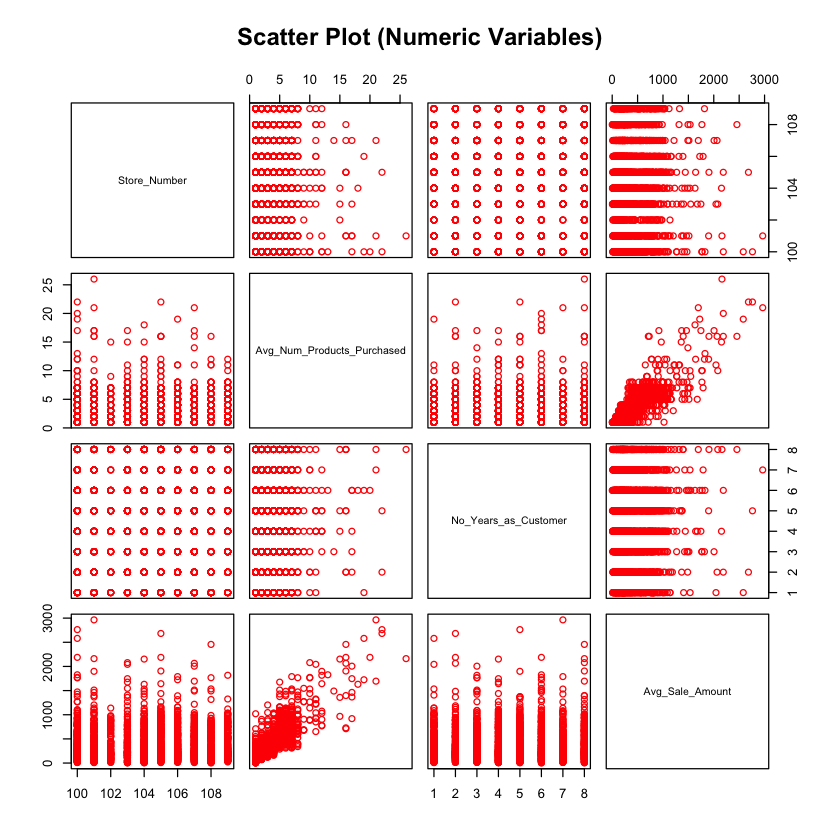

In [10]:
#Create matrix plot of numerical variables
scatter <- function(df,response='Avg_Sale_Amount'){
     nums <- sapply(df, is.numeric)
     df<-df[,nums] #plot the numeric columns
     plot(df[,1:length(df)],col="red",main="Scatter Plot (Numeric Variables)")
}
scatter(df)

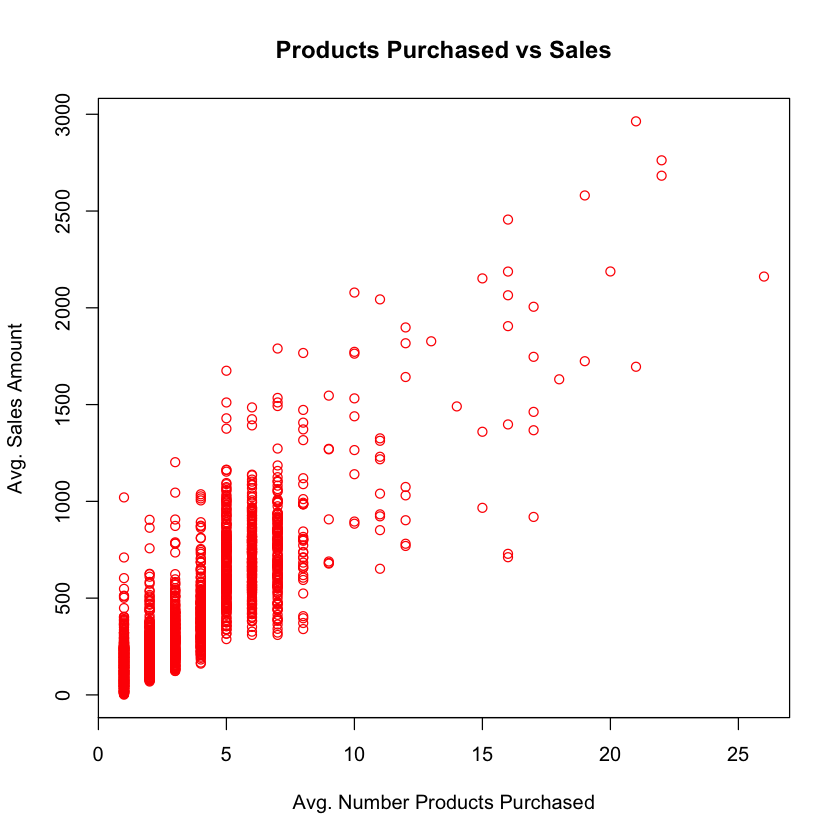

In [11]:
#Scatter Plot (Avg. Number Products Purchased vs Sales)
plot(df$Avg_Num_Products_Purchased,df$Avg_Sale_Amount,
     xlab="Avg. Number Products Purchased",ylab="Avg. Sales Amount",
     main="Products Purchased vs Sales",col="red")

### Additional Analysis

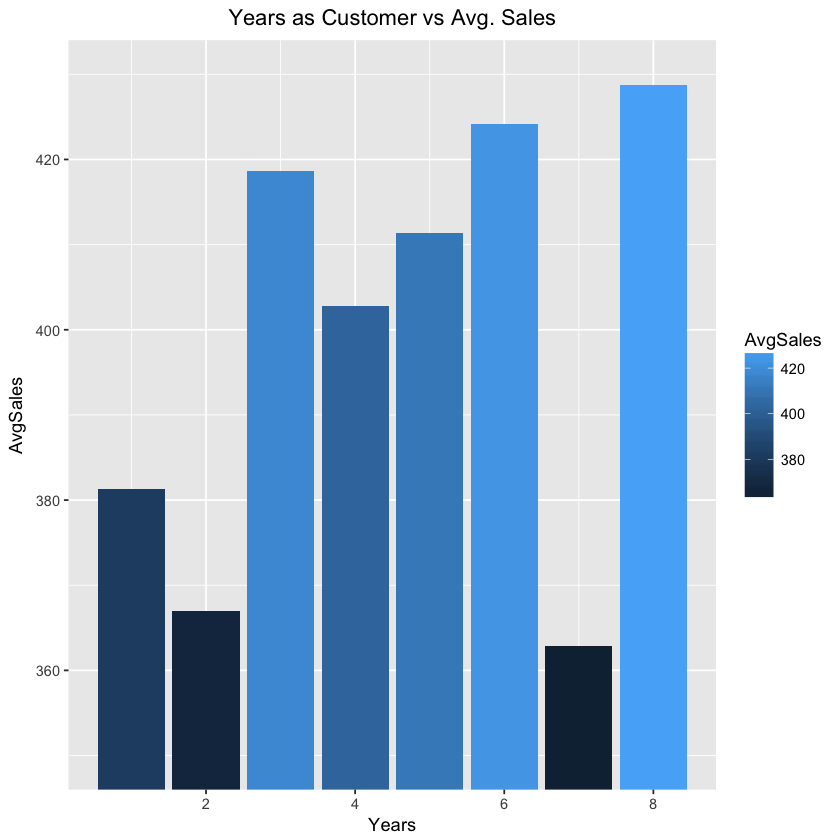

In [12]:
#Compute the average sales per years as a customer (All Customer Segments)
cust <- aggregate(df$Avg_Sale_Amount,by=list(df$No_Years_as_Customer),FUN=mean)
colnames(cust)<-c("Years","AvgSales")
p<-ggplot(data=cust,aes(Years,AvgSales,fill=AvgSales)) + geom_bar(stat="identity")
p + labs(title="Years as Customer vs Avg. Sales") + theme(plot.title=element_text(hjust=0.50))+
coord_cartesian(ylim = c(350, 430))

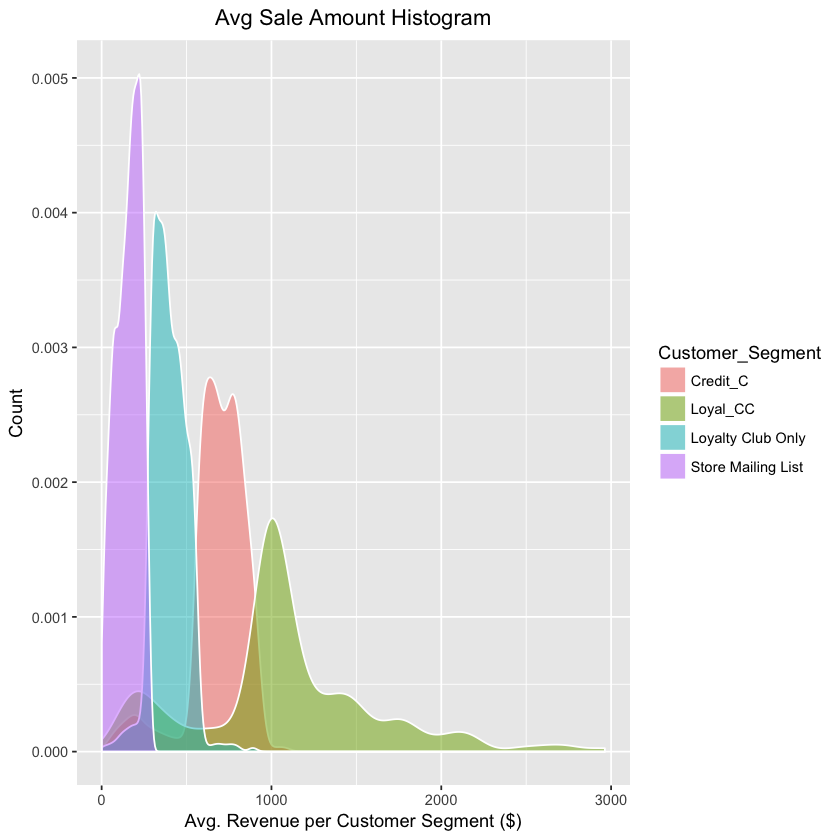

In [13]:
#Generate a density plot for average sales amount vs customer segment
p <- ggplot(data=df, aes(x=df$Avg_Sale_Amount,fill=Customer_Segment)) + geom_density(col="white",alpha=.5)
p + labs(title='Avg Sale Amount Histogram',
        x="Avg. Revenue per Customer Segment ($)",y="Count") + 
        theme(plot.title=element_text(hjust=0.50))

## Simple Linear Regression

In [14]:
#identify the x_var and response variable
x_var<-'Avg_Num_Products_Purchased'
response<-"Avg_Sale_Amount ~"

model.params <- function(response,x_var){
    var<-paste((response),paste(names(df[x_var]),collapse=""))
    var<-as.character(var)
    var<-noquote(var) #remove any quotes
    return(var)
}

In [15]:
regression_model <- function(df){    
     #construct linear regression model (simple LR)
     stat.mod <- lm(model.params(response,x_var),data=df)
     return(stat.mod)
 }
reg.model <- regression_model(df)

In [16]:
#Return Parameter Estimates for Slope & Intercept
slope<-coef(reg.model)[2] #get slope
int <- coef(reg.model)[1] #get intercept
paste("Slope:",round(slope,3)," Intercept:",round(int,3))

[1] "Slope: 106.28  Intercept: 44.015"

In [17]:
#Confidence Interval For the Parameter Estimates
confint.lm(reg.model)

,2.5 %,97.5 %
(Intercept),32.82919,55.20114
Avg_Num_Products_Purchased,103.69354,108.86682


### Create Confidence and Prediction Bands (In Progress)

In [18]:
#Specify the X_variable of interest
x_var<-'Avg_Num_Products_Purchased'

True_Pred <- function(df1,response="Avg_Sale_Amount"){
    
    #Create Dataframe to contain Y_True,Y_Pred, and Residuals    
    df_model <- df1[x_var]
    df_model['Y_true'] <- df1[response]
    
    #Predict
    pred <- predict(regression_model(df1))
    df_model['Y_pred']<- pred
   
    #Compute Residual
    df_model['Residual'] <- (df_model$Y_true - df_model$Y_pred)**2
     
    #rename columns
    cols <- c("X_True","Y_True","Y_Pred","Res")
    colnames(df_model) <- cols
    
    return(list(df_model['X_True'],df_model['Y_True'],df_model['Y_Pred'],df_model['Res']))
}

In [19]:
stats <- function(df1,x_var){
    
    #call True_Pred funtion and store as df
    df_model <- True_Pred(df1)
    
    #compute Mean Square Error
    MSE <- sum(True_Pred(df1)[[4]])
    
    #compute Root Mean Squre Error
    RMSE <- sqrt(MSE/3)
    
    #compute mean of x_var
    X_bar<-mean(df1[[x_var]])
    
    #compute sd of y_var
    sample_stdev<-sd(df1[[x_var]])
    
    return(list(MSE,RMSE,X_bar,sample_stdev))
}

In [20]:
#Confidence Band
confidence_band <- function(response="Avg_Sale_Amount"){

    #Get the length of the df1 
    #n=dim(df1[response])[1]
    n= 2
    
    #Compute the Standard Error
    df_model['SE'] <- stats(df1,x_var)[2] * sqrt((1/n) + (((True_Pred(df1)[2]-stats(df1,x_var)[3])**2)/
                      ((n-1)*(stats(df1,x_var)[4]**2))))
    
    Tcrit <- qt(1-0.05/2,(n-2))
    df_model['LCL'] <- True_Pred(df1)[3] + Tcrit*df_model$SE
    df_model['UCL'] <- True_Pred(df1)[3]- Tcrit*df_model$SE
    
    return(df_model)
    }

# confidence_band(df1)

In [270]:
df_CI <- confidence_band(df,response,x_var)
df_PI <- prediction_band(df,response,x_var)

p <- ggplot(df,aes(df$Avg_Num_Products_Purchased,df$Avg_Sale_Amount)) + 
    geom_point(size=1.5,color="blue")+ 
    geom_smooth(method = "lm", se = FALSE,color="red") + 
    #Plot Upper CI Line
    geom_line(data= df_CI, 
              aes(x=df_intervals$X_True,
                  y=df_intervals$UCL,color="blue")) +
    #Plot Lower CI Line
    geom_line(data= df_CI, 
              aes(x=df_CI$X_True,
                  y=df_CI$UCL,color="blue")) +
p + ylim(c(0,3000)) + xlim(c(0,30)) +
    labs(title="Scatter Plot",x="Avg. Number of Products Purchased",y="Avg. Sales Amount") +
    theme(plot.title=element_text(hjust=0.50))


ERROR: Error in confidence_band(df, response, x_var): unused arguments (response, x_var)


## Multiple Linear Regression
#### Constructing Model

In [21]:
#identify the response variable
response <- "Avg_Sale_Amount ~ "

In [22]:
#format the input to the regression model:
    # Y ~ X1 + X2 + X3 ...... Xn
get.multiple.xvars <- function(df,response){
    #get all column names except the last (i.e. response var)
    x <- names(df[1:(length(df)-1)]) 
    vars <- list(response)
    for(i in x){
        #loop through variable names and append to vector "vars"
        vars[i] <- paste(i,"+ ")
    }
    #concat vector as one string
    vars <- paste(vars, collapse = '')
    #substring --> grab all characters except last (i.e. "+")
    vars <-substr(vars, 1, nchar(vars)-2)
    vars <- noquote(vars)
    #remove any quotes
    return(vars)  
}

In [23]:
#Multiple Regression Model
multiple.reg.model <- function(df){
    set.seed(44)
    tcontrol <- trainControl(method="cv",number=10,savePredictions=TRUE)
    df_split <- get.response.preds(df)
    features <- as.formula(get.multiple.xvars(df,response))
    fit <- train(features,data=df_split,method="lm",metric="RMSE",trControl=tcontrol)
    return(fit)
    }

In [24]:
#Summary of model (i.e. Parameter Estimates, Std. Error, P-value)
summary(multiple.reg.model(df))

Warning message in predict.lm(modelFit, newdata):
“prediction from a rank-deficient fit may be misleading”Warning message in predict.lm(modelFit, newdata):
“prediction from a rank-deficient fit may be misleading”


Call:
lm(formula = .outcome ~ ., data = dat)

Residuals:
    Min      1Q  Median      3Q     Max 
-675.88  -66.45   -1.71   70.26  963.63 

Coefficients:
                                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)                           493.3116   122.8928   4.014 6.15e-05 ***
CityAurora                            -20.5819    11.0858  -1.857  0.06349 .  
CityBoulder                           -41.1805    80.0290  -0.515  0.60690    
CityBrighton                          -59.4890    97.6394  -0.609  0.54240    
CityBroomfield                         -4.3414    15.1242  -0.287  0.77410    
`CityCastle Pines`                    -93.0347    97.6416  -0.953  0.34078    
CityCentennial                         -9.5731    18.1580  -0.527  0.59809    
`CityCommerce City`                   -33.2255    44.4536  -0.747  0.45489    
CityDenver                              0.2317    10.5508   0.022  0.98248    
CityEdgewater                          27.9712    40.61

Warning message in predict.lm(modelFit, newdata):
“prediction from a rank-deficient fit may be misleading”Warning message in predict.lm(modelFit, newdata):
“prediction from a rank-deficient fit may be misleading”

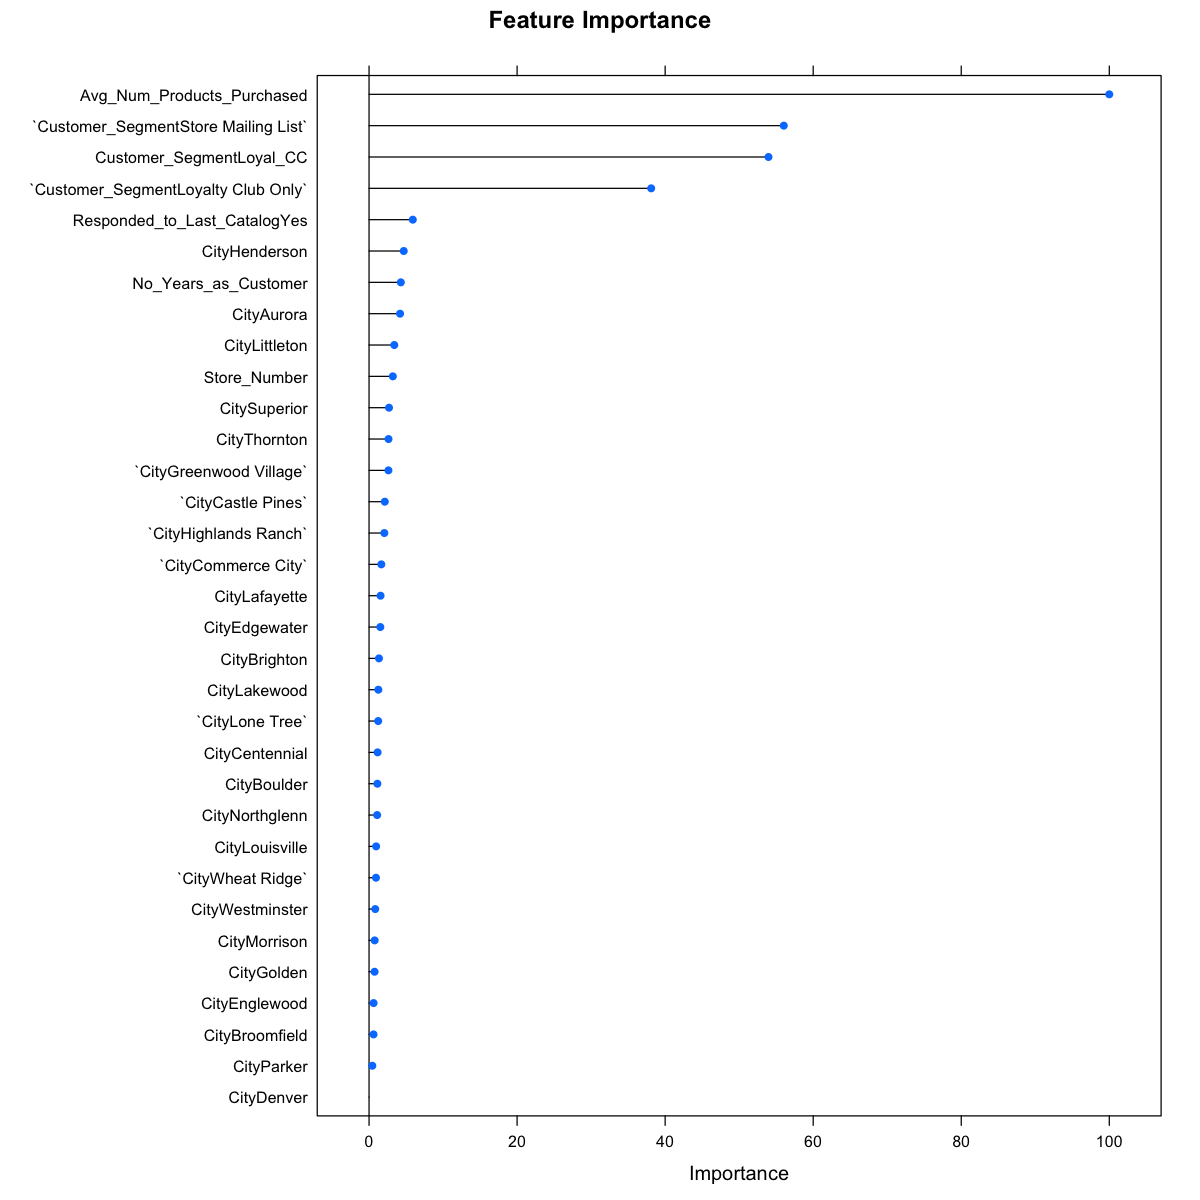

In [93]:
#Variable Importance
library(repr)
options(repr.plot.width=10, repr.plot.height=10)
plot(varImp(multiple.reg.model(df)),main="Feature Importance")

In [26]:
#Diagnostic Plots
#par(mfrow=c(2,2))
plot(multiple.reg.model(df),col="red")

Warning message in predict.lm(modelFit, newdata):
“prediction from a rank-deficient fit may be misleading”Warning message in predict.lm(modelFit, newdata):
“prediction from a rank-deficient fit may be misleading”

ERROR: Error in plot.train(multiple.reg.model(df), col = "red"): There are no tuning parameters with more than 1 value.


### Reduced Regression Model

In [31]:
get_significant_vars <- function(){
    #call regression model function and pass df
    model <- multiple.reg.model(df)
    #get only those variables that are significant (i.e. less than 0.05)
    df.sign <- data.frame(summary(model)$coef[summary(model)$coef[,4] <= 0.05, 1:4])
    #rename columns
    colnames(df.sign)<- c("Parameter Est.","Std. Error","t","P-Value")
    return(df.sign)
}

In [32]:
get_significant_vars()

Warning message in predict.lm(modelFit, newdata):
“prediction from a rank-deficient fit may be misleading”Warning message in predict.lm(modelFit, newdata):
“prediction from a rank-deficient fit may be misleading”

,Parameter Est.,Std. Error,t,P-Value
(Intercept),493.31156,122.892817,4.014161,6.153352e-05
CityHenderson,-285.83392,137.846514,-2.073567,3.822870e-02
Customer_SegmentLoyal_CC,282.78007,11.955849,23.652028,4.445722e-111
`Customer_SegmentLoyalty Club Only`,-150.64011,9.013613,-16.712511,2.539347e-59
`Customer_SegmentStore Mailing List`,-242.81518,9.887736,-24.557207,1.105811e-118
Responded_to_Last_CatalogYes,-29.57857,11.335256,-2.609431,9.127058e-03
Avg_Num_Products_Purchased,66.91471,1.527270,43.813271,9.519129e-307


In [33]:
# Remove any catagorical vars that are still insignificant
vars <- c("City","Store_Number","Responded_to_Last_Catalog","No_Years_as_Customer")

In [34]:
drop.insignificant.vars <- function(df,vars){
    # return a dataframe that does not contain the specified columns 
    df <- df[, !(colnames(df) %in% vars)]
    return(df)
}
df.r <- drop.insignificant.vars(df,vars)

### Final Model and Predictions

In [35]:
#Rerun model without the specified X_vars parameters:
summary(multiple.reg.model(df.r))


Call:
lm(formula = .outcome ~ ., data = dat)

Residuals:
    Min      1Q  Median      3Q     Max 
-663.77  -67.31   -1.90   70.69  971.69 

Coefficients:
                                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)                           303.463     10.576   28.69   <2e-16 ***
Customer_SegmentLoyal_CC              281.839     11.910   23.66   <2e-16 ***
`Customer_SegmentLoyalty Club Only`  -149.356      8.973  -16.64   <2e-16 ***
`Customer_SegmentStore Mailing List` -245.418      9.768  -25.12   <2e-16 ***
Avg_Num_Products_Purchased             66.976      1.515   44.21   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 137.5 on 2370 degrees of freedom
Multiple R-squared:  0.8369,	Adjusted R-squared:  0.8366 
F-statistic:  3040 on 4 and 2370 DF,  p-value: < 2.2e-16


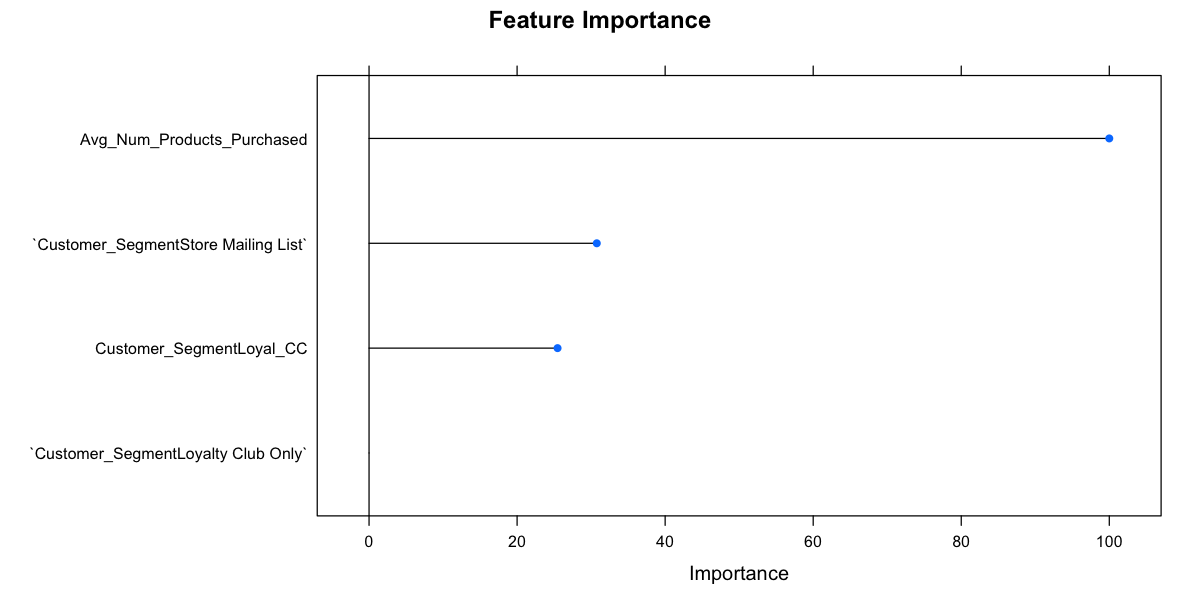

In [94]:
#Variable Importance
options(repr.plot.width=10, repr.plot.height=5)
plot(varImp(multiple.reg.model(df.r)),main="Feature Importance")

In [133]:
#Make Predictions
predicted.values <- predict(multiple.reg.model(df.r))

#Summary of Predictions
print("Predicted Data:")
summary(predicted.values)

#Summary of Observed Values
print("Observed Data:")
summary(target)

[1] "Predicted Data:"


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  125.0   125.0   288.1   399.8   638.3  2327.0 

[1] "Observed Data:"


 Avg_Sale_Amount  
 Min.   :   1.22  
 1st Qu.: 168.93  
 Median : 281.32  
 Mean   : 399.77  
 3rd Qu.: 572.40  
 Max.   :2963.49  

### Fit Diagnostics

In [113]:
residuals <- resid(multiple.reg.model(df.r))
df.predict <- cbind(target,residuals,predicted.values)

In [69]:
#Residuals vs Predicted values 
p <- ggplot(data=df.predict,aes(x=df.predict$predicted.values,y=df.predict$residuals)) + 
            geom_point(col="blue",size=2)
plot1 <- p + labs(title="Residuals vs Predicted Values",x="Predicted Values",y="Residuals") + 
    theme(plot.title=element_text(hjust=0.5))

In [70]:
#Residuals Histogram
p <- ggplot(data=df.predict,aes(df.predict$residuals)) + 
    geom_histogram(bins=30, fill=I("Blue"),col=I("White"))

plot2 <- p + labs(title="Predicted Value (Residuals)",x="Residuals",y="Count") + 
    theme(plot.title=element_text(hjust=0.5)) 

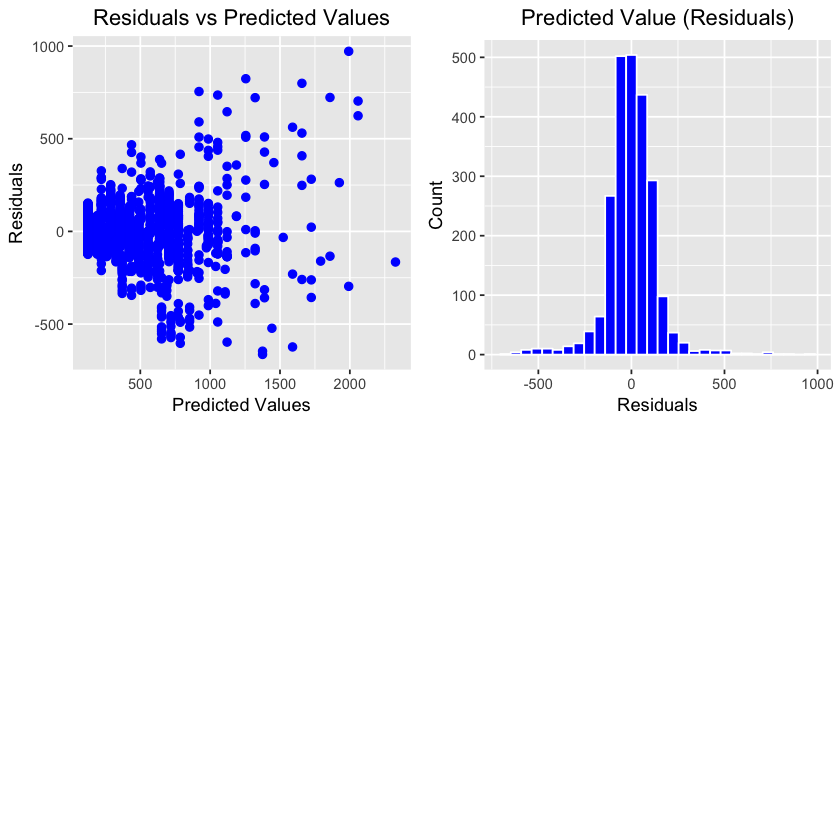

In [71]:
grid.arrange(plot1, plot2, ncol=2, heights=c(1,1), widths=c(1,1))

In [118]:
#Evaluate Model
multiple.reg.model(df.r)$results
#Compute Root Mean Squared Error to Evaluate Model Performance
rmse <- sqrt(mean((residuals)**2))
print(paste("Root Mean Squared Error: ",round(rmse,3)))

intercept,RMSE,Rsquared,RMSESD,RsquaredSD
TRUE,138.3256,0.8359228,11.52043,0.02328798


[1] "Root Mean Squared Error:  137.338"
